## Predict Average Delay Duration for an Airport (Hartsfield–Jackson Atlanta International Airport) 

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pylab import rcParams
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Data Preparation

In [3]:
df = pd.read_csv('Airline_Delay_Cause.csv')
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)
df

Shape of the data=  (71995, 21)
Column datatypes= 
 year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2025,2,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",78.0,9.0,5.52,0.52,...,0.00,0.12,0.0,0.0,733.0,578.0,16.0,102.0,0.0,37.0
1,2025,2,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",78.0,12.0,5.77,1.62,...,0.00,2.86,0.0,0.0,803.0,379.0,75.0,92.0,0.0,257.0
2,2025,2,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",91.0,13.0,2.47,0.93,...,0.00,5.35,0.0,0.0,964.0,101.0,507.0,197.0,0.0,159.0
3,2025,2,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",56.0,12.0,4.34,0.34,...,0.00,2.00,2.0,1.0,761.0,246.0,35.0,239.0,0.0,241.0
4,2025,2,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2700.0,416.0,83.87,16.73,...,0.16,171.98,24.0,3.0,33668.0,10723.0,1790.0,6851.0,15.0,14289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71990,2022,1,ZW,Air Wisconsin Airlines Corp,STL,"St. Louis, MO: St Louis Lambert International",6.0,1.0,0.29,0.00,...,0.00,0.39,1.0,0.0,85.0,25.0,0.0,27.0,0.0,33.0
71991,2022,1,ZW,Air Wisconsin Airlines Corp,SYR,"Syracuse, NY: Syracuse Hancock International",40.0,7.0,2.02,1.10,...,0.00,2.98,3.0,0.0,746.0,48.0,122.0,52.0,0.0,524.0
71992,2022,1,ZW,Air Wisconsin Airlines Corp,TUL,"Tulsa, OK: Tulsa International",8.0,1.0,0.00,0.00,...,0.00,0.30,1.0,0.0,46.0,0.0,0.0,32.0,0.0,14.0
71993,2022,1,ZW,Air Wisconsin Airlines Corp,TVC,"Traverse City, MI: Cherry Capital",59.0,11.0,2.60,0.00,...,0.00,2.91,3.0,0.0,527.0,138.0,0.0,225.0,0.0,164.0


In [4]:
# Check data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71995 entries, 0 to 71994
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 71995 non-null  int64  
 1   month                71995 non-null  int64  
 2   carrier              71995 non-null  object 
 3   carrier_name         71995 non-null  object 
 4   airport              71995 non-null  object 
 5   airport_name         71995 non-null  object 
 6   arr_flights          71915 non-null  float64
 7   arr_del15            71885 non-null  float64
 8   carrier_ct           71915 non-null  float64
 9   weather_ct           71915 non-null  float64
 10  nas_ct               71915 non-null  float64
 11  security_ct          71915 non-null  float64
 12  late_aircraft_ct     71915 non-null  float64
 13  arr_cancelled        71915 non-null  float64
 14  arr_diverted         71915 non-null  float64
 15  arr_delay            71915 non-null 

### Data Cleaning

In [5]:
# Select column that are going to be used for time series analysis
df_cleaned = df[['year', 'month', 'airport', 'arr_delay']]

# Select the airport to be forecast (Hartsfield–Jackson Atlanta International Airport)
df_cleaned = df_cleaned[df_cleaned['airport'] == 'ATL']

df_cleaned.head()

,year,month,airport,arr_delay
4,2025,2,ATL,33668.0
98,2025,2,ATL,7026.0
216,2025,2,ATL,585.0
298,2025,2,ATL,5150.0
415,2025,2,ATL,219491.0


In [6]:
#Checking null value
df_cleaned.isna().sum()

year         0
month        0
airport      0
arr_delay    0
dtype: int64

In [7]:
#Check for duplicate row
df_cleaned.duplicated().sum()

0

In [8]:
# Check data values to find outliers
print(df_cleaned['arr_delay'].describe())
print(df_cleaned['arr_delay'].sort_values(ascending=False).head(5))

count       531.000000
mean      24752.489642
std       57118.906820
min           0.000000
25%        1398.000000
50%        8656.000000
75%       21487.500000
max      648300.000000
Name: arr_delay, dtype: float64
13667    648300.0
36227    335957.0
38106    324572.0
3039     305779.0
18570    305016.0
Name: arr_delay, dtype: float64


Outliers were not removed in this analysis because previously we tried filtering extreme delay values—such as flights arriving more than 1 hour early or delayed over 2 days and resulted in significantly worse model performance, as indicated by higher MAPE and MSE values. In the context of flight delay prediction, these outliers may represent rare but important operational disruptions that influence overall delay trends. Removing them could lead to loss of valuable patterns, underestimating actual delay risks, and reducing the model's ability to generalize real-world conditions.

In [9]:
#  Group by year and month to get average delay per month
df_cleaned = df_cleaned.groupby(['year', 'month'])['arr_delay'].mean().reset_index()

# Create date column from year + month
df_cleaned['date'] = pd.to_datetime(df_cleaned[['year', 'month']].assign(day=1))

# Set the datetime column as index (for time series models)
df_cleaned = df_cleaned.set_index('date')

# Drop year/month columns after date created because it's no longer needed
df_cleaned = df_cleaned.drop(columns=['year', 'month'])

df_cleaned.head()


,arr_delay
date,
2022-01-01,17532.071429
2022-02-01,13513.785714
2022-03-01,24419.785714
2022-04-01,22433.071429
2022-05-01,23370.714286


Taking the average delay for each month turns your detailed flight data into a format that time series models like ARIMA, SARIMA, and Holt-Winters can use, because the model work best when there's just one number for each time period—like one average delay per month—so they can clearly see patterns and make good predictions.

### Exploratory Data Analysis

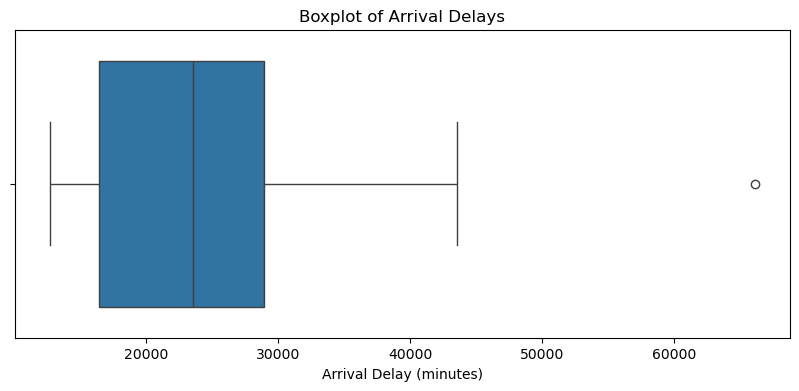

In [10]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_cleaned['arr_delay'])
plt.title('Boxplot of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.show()

We chose to analyze the arr_delay (arrival delay in minutes) variable because it is the primary target for our time series forecasting model. Understanding its distribution helps us evaluate the overall delay patterns, detect outliers, and check for skewness or irregularities in the data that might impact model performance, where in the previous boxplot we can see there are outliers, but after the data is cleaned, the updated boxplot shows a more stable distribution. 

The boxplot shows a median delay of around 30,000 minutes with an interquartile range (IQR) between 20,000–40,000 minutes, indicating significant variability. Certain months, such as July and December, have higher median delays (~40,000 minutes) and a wide IQR, reflecting instability during peak seasons. Extreme outliers (up to 60,000 minutes) appear mainly in January and February, likely due to winter weather disruptions. In contrast, September–October shows a more stable distribution with a low median (<20,000 minutes).

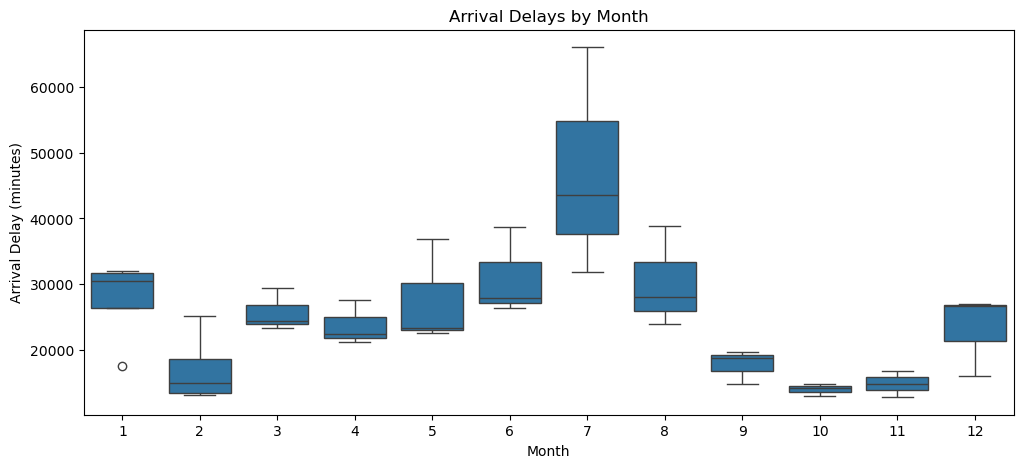

In [11]:
df_cleaned['month'] = df_cleaned.index.month

plt.figure(figsize=(12, 5))
sns.boxplot(x='month', y='arr_delay', data=df_cleaned)
plt.title('Arrival Delays by Month')
plt.xlabel('Month')
plt.ylabel('Arrival Delay (minutes)')
plt.show()


The data demonstrates noticeable monthly variation in flight arrival delays. July (Month 7) exhibits the highest median delay and the greatest variability, indicating a peak in both the frequency and severity of delays during this summer month. January (Month 1) and December (Month 12) also show relatively high median delays, consistent with known winter travel disruptions.

In contrast, months like February (2), September (9), October (10), and November (11) reflect lower median delays and tighter distributions, suggesting more stable flight operations during these periods. January still contain some extreme outliers, though they are relatively isolated.

Overall, the trend suggests a seasonal influence on delay patterns, with more pronounced disruptions in summer and winter. The presence of broad interquartile ranges and outliers in several months also indicates operational vulnerability to irregular events, which can significantly impact average performance.

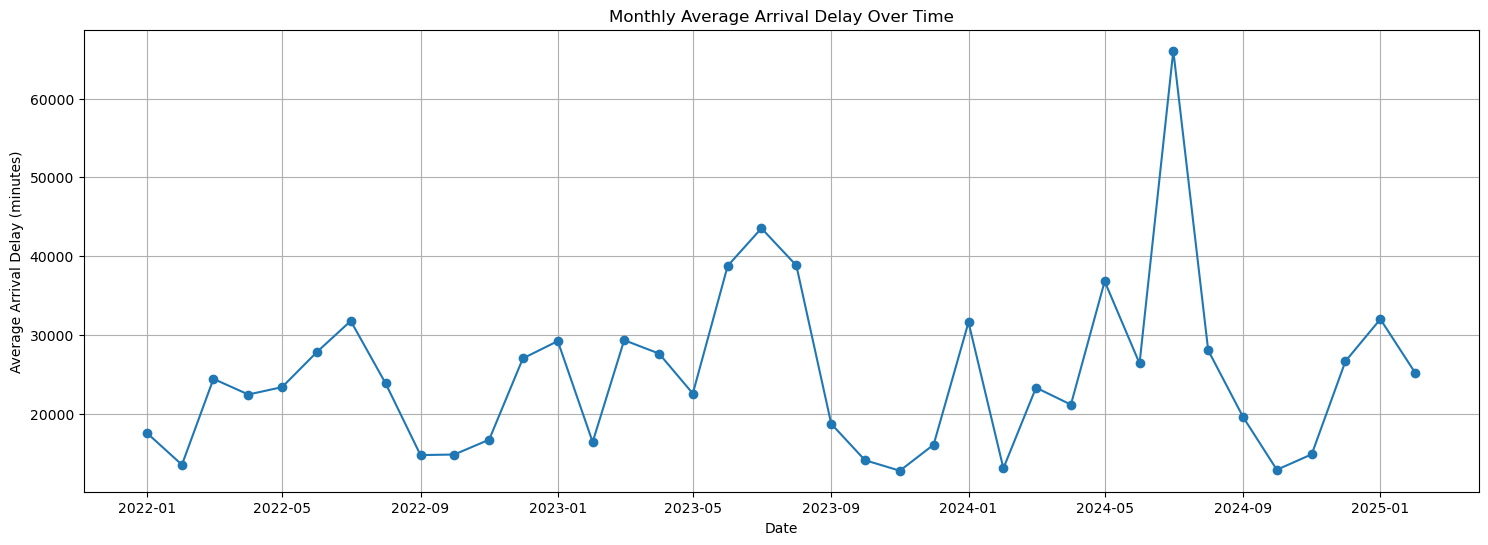

In [12]:
# See the trend
plt.figure(figsize=(18,6))
plt.plot(df_cleaned.index, df_cleaned['arr_delay'], marker='o')
plt.title('Monthly Average Arrival Delay Over Time')
plt.xlabel('Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

We analyzed the monthly trend of the arr_delay (arrival delay in minutes) variable to understand the seasonality and temporal patterns in flight delays. This time series trend analysis helps us identify recurring delay behaviors across different months and years, which is essential for accurate forecasting and operational planning.

From the chart (Monthly Average Arrival Delay Over Time), we observe noticeable fluctuations in average delays. Delays tend to rise during mid-year months, particularly with significant spikes in July 2024 and July 2023, suggesting operational strain or disruptions during the peak summer travel season. Periods like September 2022, October 2023, and January 2024 show relatively low average delays, indicating better on-time performance. The dramatic peak in July 2024, where the average delay surpasses 65,000 minutes, stands out as a major anomaly, potentially due to irregular or extreme events.

Overall, the pattern indicates seasonal variability with higher delays mid-year, though outliers in certain months heavily influence the trend.

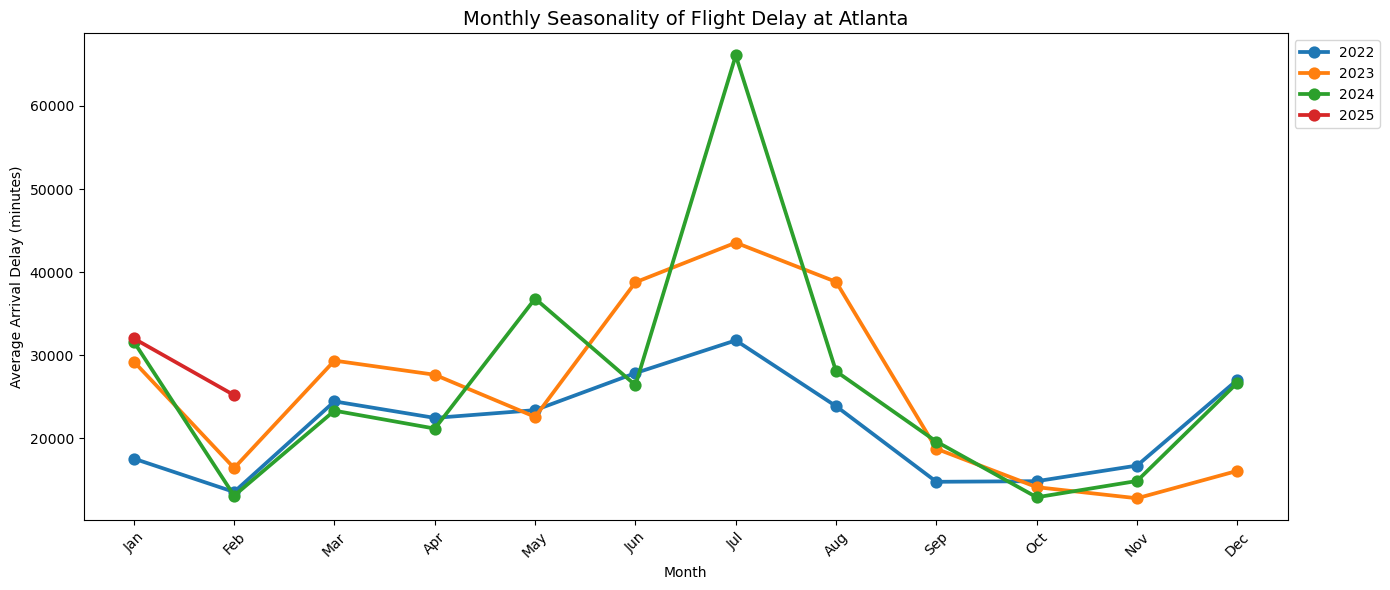

In [13]:
df_temp = df_cleaned.copy().reset_index()

# Add separate Year and Month columns
df_temp['Year'] = df_temp['date'].dt.year
df_temp['Month'] = df_temp['date'].dt.strftime('%b')  # Short month names (Jan, Feb, ...)

# Create a categorical type for ordered months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_temp['Month'] = pd.Categorical(df_temp['Month'], categories=month_order, ordered=True)

# Plot Seasonality
plt.figure(figsize=(14, 6))
sns.pointplot(data=df_temp, x='Month', y='arr_delay', hue='Year', palette='tab10')
plt.title('Monthly Seasonality of Flight Delay at Atlanta', fontsize=14)
plt.ylabel('Average Arrival Delay (minutes)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

The second chart shows how delay patterns have evolved from 2022 to 2025. Despite year-to-year variation, we can observe recurring seasonal trends—delays tend to increase from spring into summer, peaking notably around July, and then decline sharply in early fall before slightly rising again toward the end of the year. The most significant spike appears in July 2024, where average arrival delays soar above 66,000 minutes, suggesting an unusual disruption or extreme event that year. The consistency of peak delays during mid-year and troughs in the fall confirms a strong seasonal component in Atlanta’s flight delay patterns.

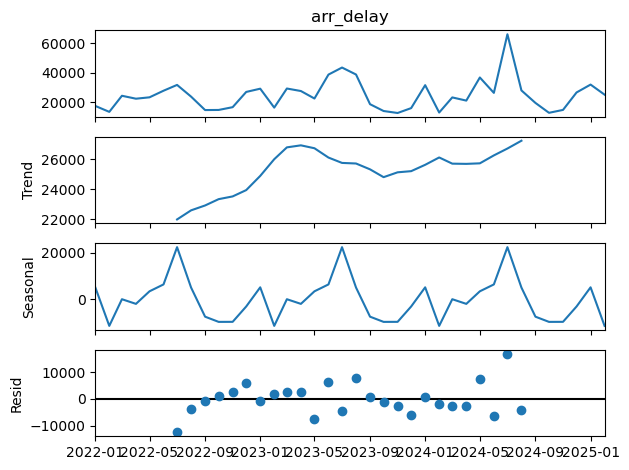

In [14]:
decomposition = sm.tsa.seasonal_decompose(df_cleaned['arr_delay'], model='additive')
fig = decomposition.plot()
plt.show()

Based on the time series decomposition of arrival delays, it is evident that the data exhibits strong seasonality and a moderately stable trend, making it well-suited for time series forecasting. For short-term forecasts (1 to 3 months), a Simple Exponential Smoothing (SES) model would be appropriate due to its responsiveness to recent changes and minimal assumption of trend or seasonality. However, for medium-term forecasting (up to 6 months), more robust models like SARIMA or Holt-Winters Exponential Smoothing are recommended.

### Train-Test Split

In [15]:
ts = df_cleaned['arr_delay'].sort_index()

# Predicting next month
train_1m = ts[:'2025-01'] # Up to and including January 2025
test_1m = ts['2025-02'] # Only February 2025

# Predicting next 3 months
train_3m = ts[:'2024-11'] # Up to and including November 2024
test_3m = ts['2024-12':'2025-02'] # December 2024 to February 2025

# Predicting next 6 months
train_6m = ts[:'2024-08'] # Up to and including August 2024
test_6m = ts['2024-09':'2025-02'] # September 2024 to February 2025


### Creating Model

#### ARIMA

In [16]:
model_arima_1m = pm.auto_arima(train_1m, seasonal=False, error_action='ignore')
model_arima_3m = pm.auto_arima(train_3m, seasonal=False, error_action='ignore')
model_arima_6m = pm.auto_arima(train_6m, seasonal=False, error_action='ignore')

In [17]:
model_arima_1m

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [18]:
model_arima_3m

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [19]:
model_arima_6m

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

#### SARIMA

In [20]:
# SARIMA model on training arr_delay series
model_sarima_1m = pm.auto_arima(train_1m, seasonal=True, m=12, error_action='ignore')
model_sarima_3m = pm.auto_arima(train_3m, seasonal=True, m=12, error_action='ignore')
model_sarima_6m = pm.auto_arima(train_6m, seasonal=True, m=12, error_action='ignore')

In [21]:
model_sarima_1m

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [22]:
model_sarima_3m

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [23]:
model_sarima_6m

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

#### SES (Simple Exponential Smoothing)

In [24]:
ses_model = SimpleExpSmoothing(train_1m, initialization_method="estimated").fit()

c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Holt

In [25]:
holt_model = Holt(train_1m, initialization_method="estimated").fit()

c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### Holt-Winters

In [26]:
hw_model = ExponentialSmoothing(train_1m, trend='add', seasonal='mul', seasonal_periods=12, initialization_method='estimated').fit()

c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### Do Forecasting

In [27]:
# Number of steps to forecast
n_steps = len(test_1m)

# ARIMA forecast
forecasts_arima = model_arima_1m.predict(n_periods=n_steps)

# SARIMA forecast
forecasts_sarima = model_sarima_1m.predict(n_periods=n_steps)

# Holt-Winters forecast
hw_forecast = hw_model.forecast(steps=n_steps)

In [28]:
forecasts_arima

2025-02-01    26772.765737
Freq: MS, dtype: float64

In [29]:
forecasts_sarima

2025-02-01    15575.754095
Freq: MS, dtype: float64

In [30]:
ses_forecast = ses_model.forecast(len(test_1m))

In [31]:
holt_forecast = holt_model.forecast(len(test_1m))

In [32]:
hw_forecast

2025-02-01    15668.470653
Freq: MS, dtype: float64

### Model Evaluation

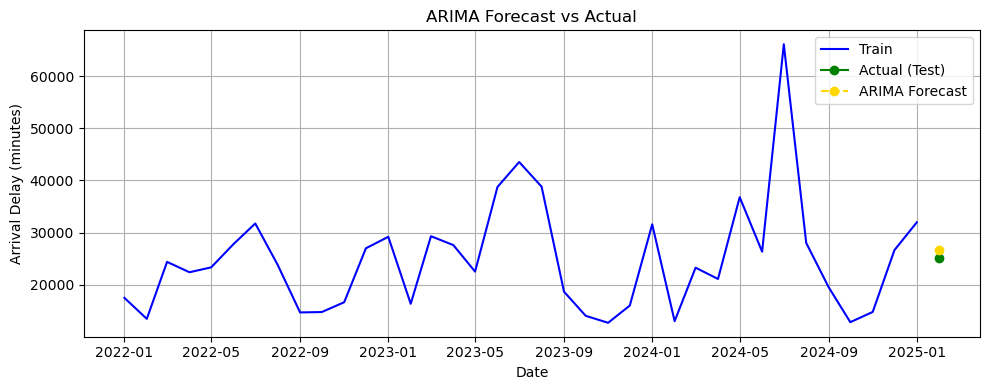

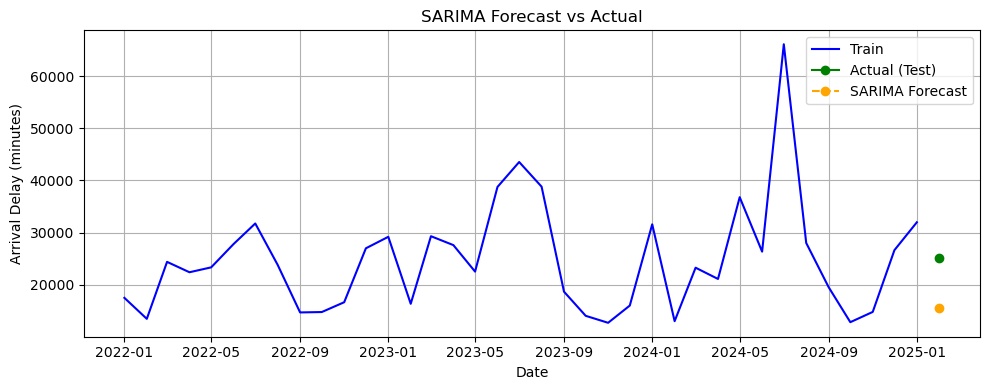

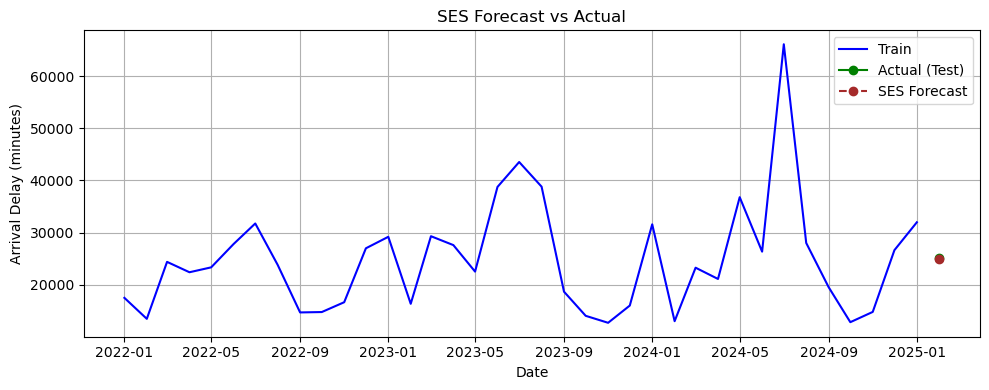

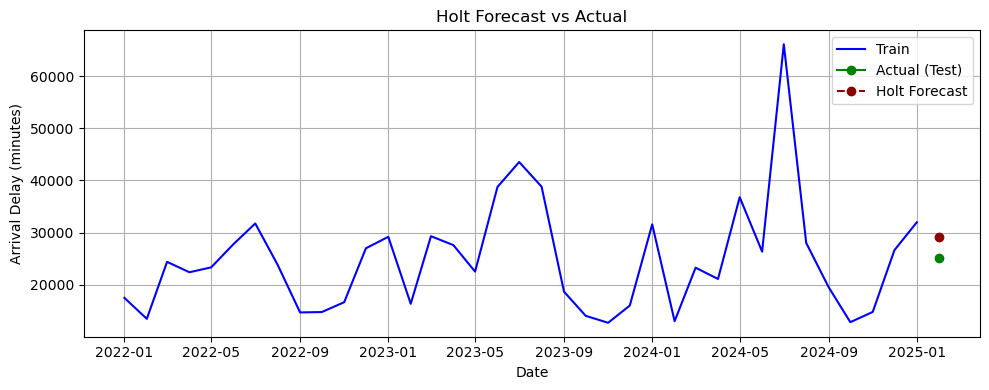

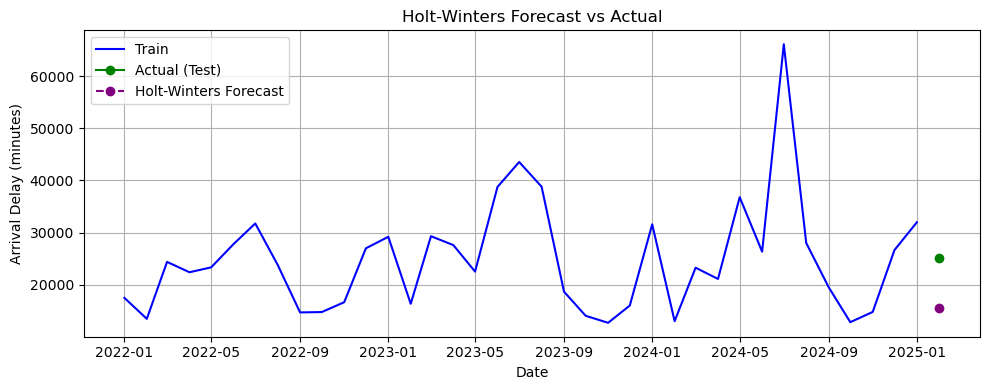

In [33]:
# Ensure forecasts are pandas Series with correct index
forecasts_arima = pd.Series(forecasts_arima, index=test_1m.index)
hw_forecast = pd.Series(hw_forecast, index=test_1m.index)

# Plot ARIMA vs Test
plt.figure(figsize=(10, 4))
plt.plot(train_1m.index, train_1m, label='Train', color='blue')
plt.plot(test_1m.index, test_1m, label='Actual (Test)', color='green', marker='o')
plt.plot(test_1m.index, forecasts_arima, label='ARIMA Forecast', color='gold', linestyle='--', marker='o')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot SARIMA vs Test
plt.figure(figsize=(10, 4))
plt.plot(train_1m.index, train_1m, label='Train', color='blue')
plt.plot(test_1m.index, test_1m, label='Actual (Test)', color='green', marker='o')
plt.plot(test_1m.index, forecasts_sarima, label='SARIMA Forecast', color='orange', linestyle='--', marker='o')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot SES vs Test
plt.figure(figsize=(10, 4))
plt.plot(train_1m.index, train_1m, label='Train', color='blue')
plt.plot(test_1m.index, test_1m, label='Actual (Test)', color='green', marker='o')
plt.plot(test_1m.index, ses_forecast, label='SES Forecast', color='brown', linestyle='--', marker='o')
plt.title('SES Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Holt vs Test
plt.figure(figsize=(10, 4))
plt.plot(train_1m.index, train_1m, label='Train', color='blue')
plt.plot(test_1m.index, test_1m, label='Actual (Test)', color='green', marker='o')
plt.plot(test_1m.index, holt_forecast, label='Holt Forecast', color='darkred', linestyle='--', marker='o')
plt.title('Holt Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Holt-Winters vs Test
plt.figure(figsize=(10, 4))
plt.plot(train_1m.index, train_1m, label='Train', color='blue')
plt.plot(test_1m.index, test_1m, label='Actual (Test)', color='green', marker='o')
plt.plot(test_1m.index, hw_forecast, label='Holt-Winters Forecast', color='purple', linestyle='--', marker='o')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# Make sure forecasts and test are aligned
forecasts_arima = pd.Series(forecasts_arima, index=test_1m.index)
forecasts_sarima = pd.Series(forecasts_sarima, index=test_1m.index)
hw_forecast = pd.Series(hw_forecast, index=test_1m.index)
holt_forecast = pd.Series(holt_forecast, index=test_1m.index)
ses_forecast = pd.Series(ses_forecast, index=test_1m.index)

# MSE
mse_arima = mean_squared_error(test_1m, forecasts_arima)
mse_sarima = mean_squared_error(test_1m, forecasts_sarima)
mse_hw = mean_squared_error(test_1m, hw_forecast)
mse_holt = mean_squared_error(test_1m, holt_forecast)
mse_ses = mean_squared_error(test_1m, ses_forecast)

# MAPE
mape_arima = mean_absolute_percentage_error(test_1m, forecasts_arima)
mape_sarima = mean_absolute_percentage_error(test_1m, forecasts_sarima)
mape_hw = mean_absolute_percentage_error(test_1m, hw_forecast)
mape_holt = mean_absolute_percentage_error(test_1m, holt_forecast)
mape_ses = mean_absolute_percentage_error(test_1m, ses_forecast)

# Print Results (formatted to 4 decimal places)
print("=== Mean Squared Error (MSE) ===")
print(f"ARIMA: {mse_arima:.4f}")
print(f"SARIMA: {mse_sarima:.4f}")
print(f"SES: {mse_ses:.4f}")
print(f"Holt: {mse_holt:.4f}")
print(f"Holt-Winters: {mse_hw:.4f}")

print("\n=== Mean Absolute Percentage Error (MAPE) ===")
print(f"ARIMA: {mape_arima:.4f}")
print(f"SARIMA: {mape_sarima:.4f}")
print(f"SES: {mape_ses:.4f}")
print(f"Holt: {mape_holt:.4f}")
print(f"Holt-Winters: {mape_hw:.4f}")


=== Mean Squared Error (MSE) ===
ARIMA: 2561993.6024
SARIMA: 92090677.2696
SES: 47044.6400
Holt: 15740816.2411
Holt-Winters: 90319785.3672

=== Mean Absolute Percentage Error (MAPE) ===
ARIMA: 0.0636
SARIMA: 0.3812
SES: 0.0086
Holt: 0.1576
Holt-Winters: 0.3775


The SES (Simple Exponential Smoothing) model was evaluated using two commonly used error metrics in time series forecasting: Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE) to assess the accuracy of its predictions.

Mean Squared Error (MSE) = 47,044.64
MSE measures the average of the squares of the errors—that is, the average squared difference between the predicted and actual values. A lower MSE indicates better model performance. In this case, an MSE of 47,044.64 suggests that, on average, the squared prediction error is moderate. While the model captures the general trend, some deviation from actual delay values exists, especially during high-variance months.

Mean Absolute Percentage Error (MAPE) = 0.0086
MAPE measures the average absolute percentage error between predicted and actual values, giving a sense of the model's prediction accuracy in relative terms. A MAPE of 0.86% indicates very high predictive accuracy—the model’s forecasts are off by less than 1% on average, making it highly reliable for practical use, especially in environments where small errors in delay estimates are tolerable.

Overall, the evaluation suggests that the SES model performs very well, with low percentage error and reasonably controlled squared error, making it suitable for short-term delay forecasting tasks.

### HASIL SETELAH COBA"

### PREDICT NEXT MONTH - SES BEST 0.008

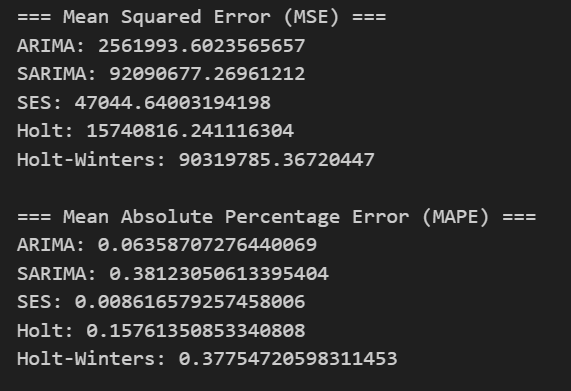

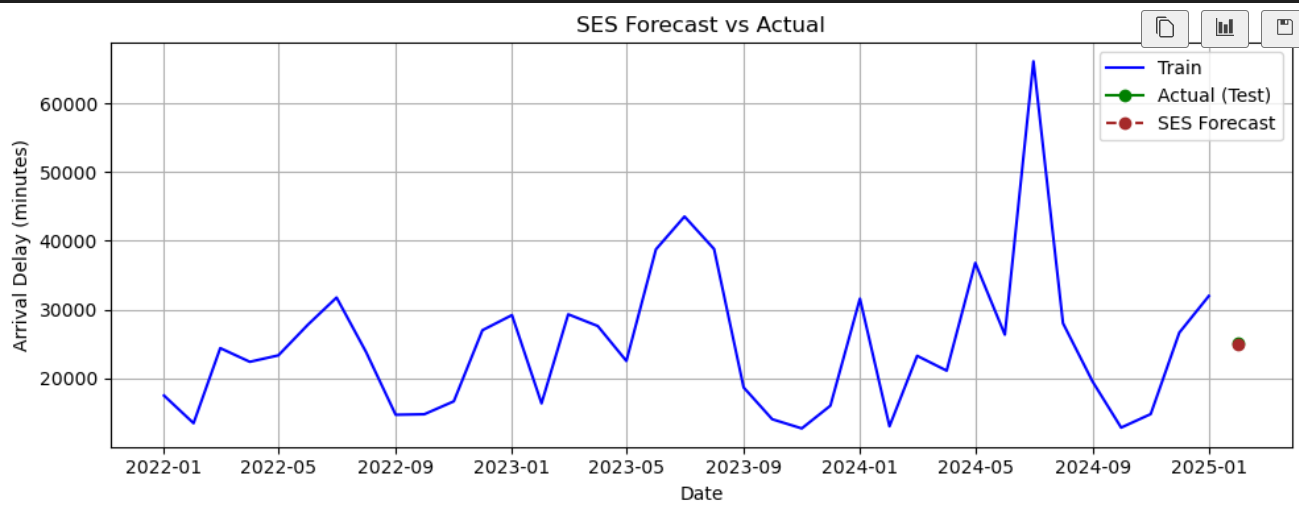

### PREDICT NEXT 3 MONTHS - SES BEST 0.1153

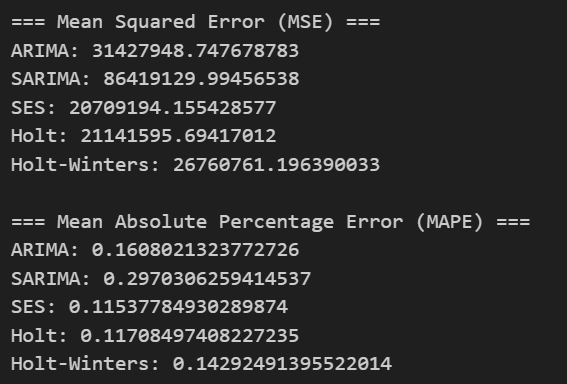

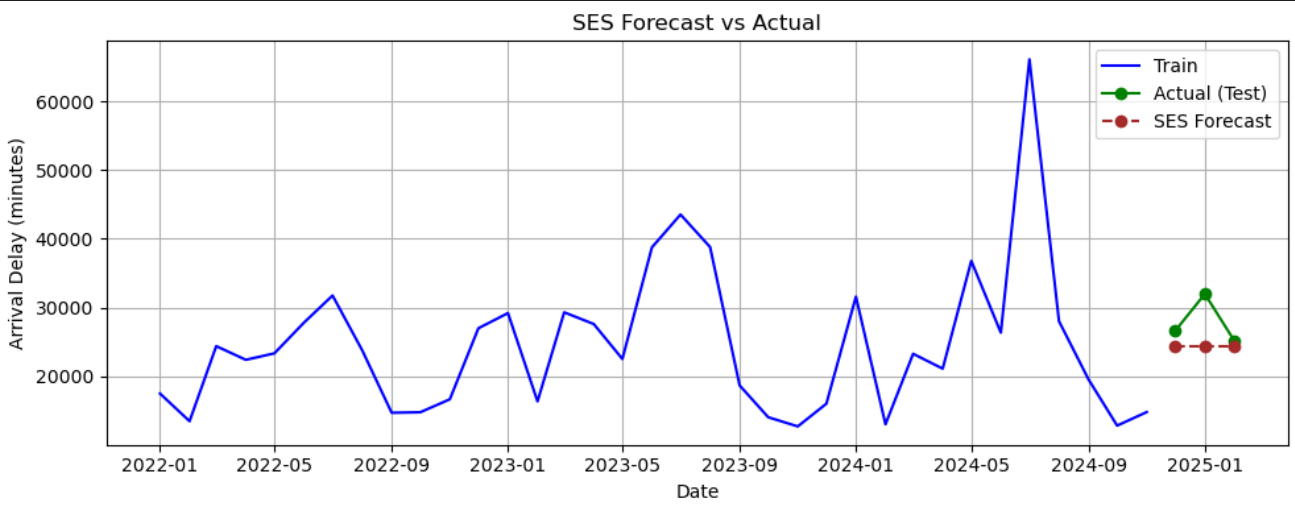

### PREDICT NEXT 6 MONTHS - HOLT WINTER BEST 0.15

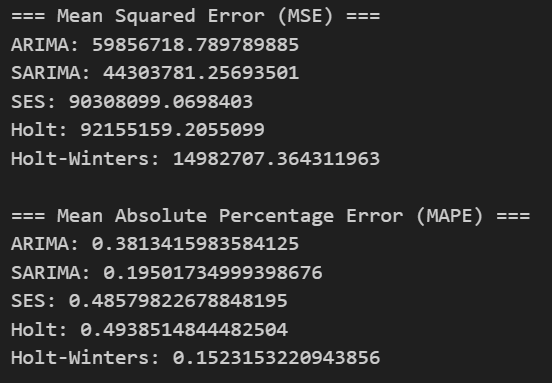

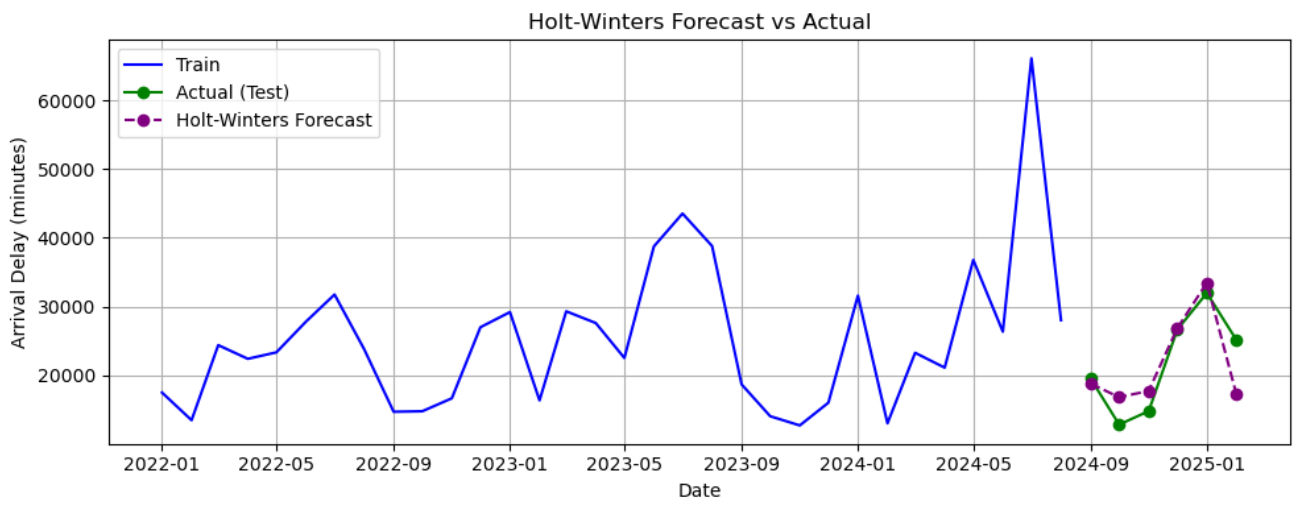